<a href="https://colab.research.google.com/github/apthagowda97/computer_vision_poc/blob/master/GAN/dcgan_mnist_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [0]:
import cv2

In [0]:
latent_dim = 10

In [243]:
(X_train, y_train),( X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

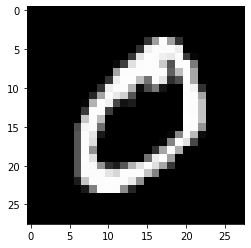

In [244]:
img = cv2.cvtColor(X_train[1],cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [0]:
X_train = X_train[0:5000]

In [0]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:,:,:,np.newaxis]

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [0]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape(( 7, 7,128)))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [249]:
generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 28, 28, 64)      

In [0]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=( 28, 28,1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)


In [251]:
discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)            

In [0]:
discriminator.trainable = False

In [0]:
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


In [254]:
gan.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


In [0]:
dLosses = []
gLosses = []

In [0]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [0]:
def plotGeneratedImages(epoch, examples=20, dim=(2, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples,latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i].reshape(28,28), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

In [0]:
epochs = 5
batchSize = 128
batchCount = X_train.shape[0] / batchSize

--------------- Epoch 1 ---------------



--------------- Epoch 2 ---------------



--------------- Epoch 3 ---------------



--------------- Epoch 4 ---------------



--------------- Epoch 5 ---------------


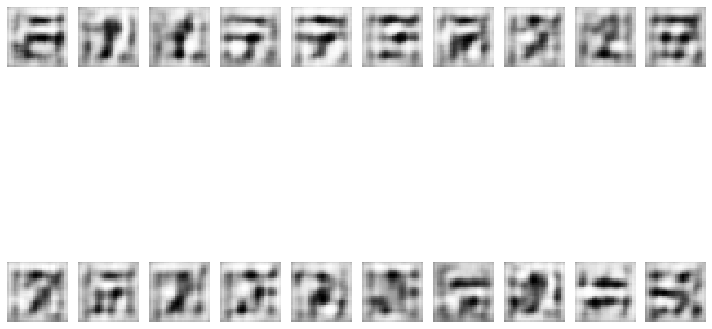

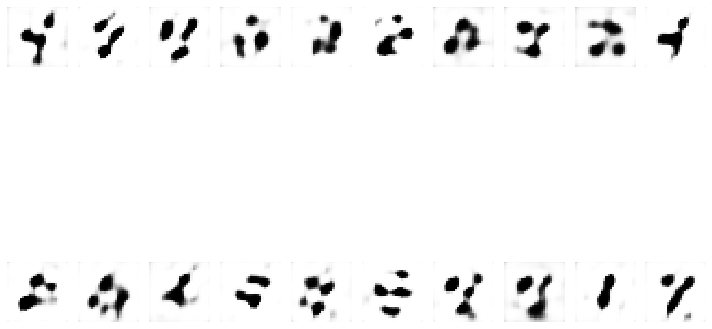

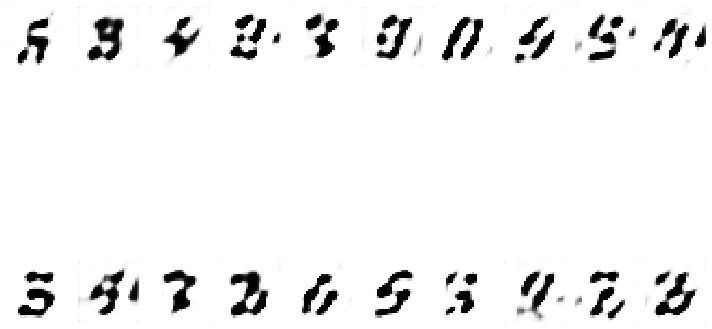

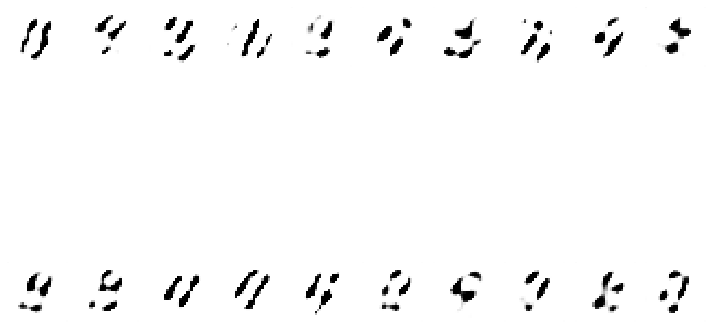

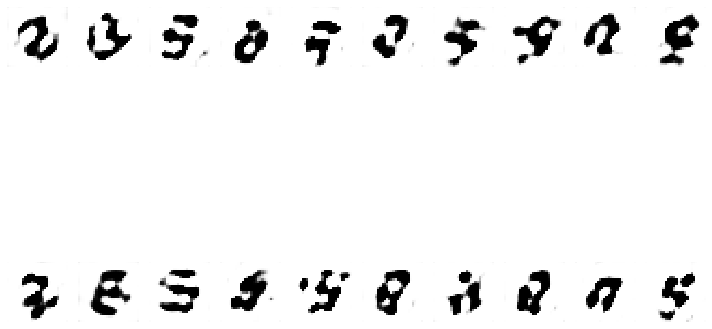

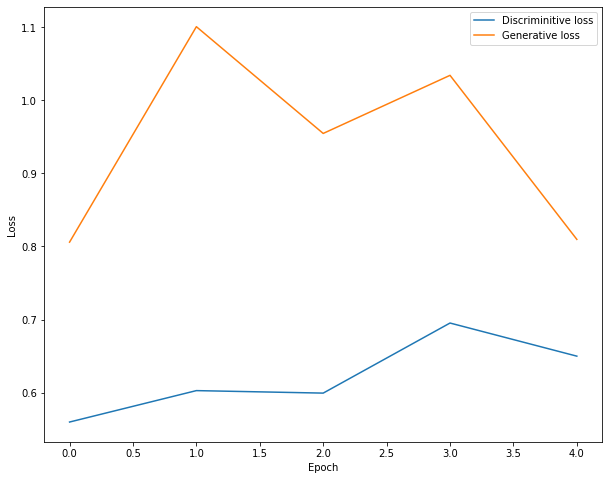

In [259]:
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm_notebook(range(int(batchCount))):
        noise = np.random.normal(0, 1, size=[batchSize,latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize,latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
 
    dLosses.append(dloss)
    gLosses.append(gloss)

    plotGeneratedImages(e)
plotLoss(e)